#SENTIMENT ANALYSIS OF COVID-19 TWEETS

In [ ]:
#import necessary libraries 
import io
import random
import string
import warnings
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings('ignore')




import nltk
from nltk.tokenize import sent_tokenize
from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *


# sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics


# python imports
import re
import json
import os
from collections import Counter
import datetime as dt


# Visualization
from matplotlib import pyplot as plt
from matplotlib import ticker
import seaborn as sns
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from wordcloud import WordCloud
from tqdm import tqdm_notebook


# Saving models
import pickle


In [ ]:
df = pd.read_csv("/content/ Coronavirus_Tweets.csv", encoding = 'latin-1')


In [ ]:
df.head()

,status_id,user_id,created_at,screen_name,text,source,reply_to_status_id,reply_to_user_id,reply_to_screen_name,is_quote,is_retweet,favourites_count,retweet_count,country_code,place_full_name,place_type,followers_count,friends_count,account_lang,account_created_at,verified,lang
0,1.244050e+18,8.602530e+17,2020-03-29T00:00:00Z,IMSS_SanLuis,"Ante cualquier enfermedad respiratoria, no te ...",TweetDeck,NaN,NaN,NaN,False,False,300,0,NaN,NaN,NaN,1008,41,NaN,2017-05-04T22:00:38Z,False,es
1,1.244050e+18,1.125930e+18,2020-03-29T00:00:00Z,intrac_ccs,#ATENCIÌÒN En el Terminal Nuevo Circo se imple...,TweetDeck,NaN,NaN,NaN,False,False,1030,1,NaN,NaN,NaN,90,316,NaN,2019-05-08T01:21:16Z,False,es
2,1.244050e+18,8.094356e+07,2020-03-29T00:00:00Z,rlieving,ÛÏPeople are just storing up. They are stayin...,TweetDeck,NaN,NaN,NaN,False,False,604,0,NaN,NaN,NaN,136,457,NaN,2009-10-08T21:06:08Z,False,en
3,1.244050e+18,8.170720e+17,2020-03-29T00:00:00Z,Tu_IMSS_Coah,"Si empezaste a trabajar, necesitas dar de alta...",TweetDeck,NaN,NaN,NaN,False,False,1827,0,NaN,NaN,NaN,1549,170,NaN,2017-01-05T18:17:00Z,False,es
4,1.244050e+18,7.888640e+17,2020-03-29T00:00:00Z,Tabasco_IMSS,Una sociedad informada estÌÁ mejor preparada a...,TweetDeck,NaN,NaN,NaN,False,False,723,0,NaN,NaN,NaN,868,125,NaN,2016-10-19T22:05:03Z,False,es


In [ ]:
df.tail()

,status_id,user_id,created_at,screen_name,text,source,reply_to_status_id,reply_to_user_id,reply_to_screen_name,is_quote,is_retweet,favourites_count,retweet_count,country_code,place_full_name,place_type,followers_count,friends_count,account_lang,account_created_at,verified,lang
564136,1.244410e+18,1.028780e+18,2020-03-29T23:59:58Z,tmcrypto1,A 3rd #NYPD member dies of #coronavirus after ...,Twitter for iPhone,NaN,NaN,NaN,False,False,2526,0,NaN,NaN,NaN,85,123,NaN,2018-08-12T23:21:07Z,False,en
564137,1.244410e+18,8.119196e+07,2020-03-29T23:59:59Z,CALcharters,"For many students in our state, #COVID19 closu...",HubSpot,NaN,NaN,NaN,False,False,4656,2,NaN,NaN,NaN,8104,2798,NaN,2009-10-09T20:10:36Z,True,en
564138,1.244410e+18,6.120661e+07,2020-03-29T23:59:59Z,npquarterly,Will the #coronavirus pandemic of 2020 come to...,HubSpot,NaN,NaN,NaN,False,False,2916,2,NaN,NaN,NaN,127869,3046,NaN,2009-07-29T14:27:16Z,False,en
564139,1.244410e+18,2.598147e+08,2020-03-29T23:59:59Z,ksharizal,Tahniah #xaffani #xaffanisrikandi semoga our f...,Twitter for Android,NaN,NaN,NaN,False,False,1169,0,NaN,NaN,NaN,413,175,NaN,2011-03-02T17:12:10Z,False,in
564140,1.244410e+18,9.388810e+17,2020-03-29T23:59:59Z,MeL8tleigh,_Ù___ÙÈÛªÛü Is there a way to revoke som...,Twitter for iPhone,NaN,NaN,NaN,True,False,35055,0,NaN,NaN,NaN,302,384,NaN,2017-12-07T21:21:24Z,False,en


In [ ]:
df.describe()

,status_id,user_id,reply_to_status_id,reply_to_user_id,favourites_count,retweet_count,followers_count,friends_count,account_lang
count,5.641410e+05,5.641410e+05,7.596700e+04,9.083400e+04,5.641410e+05,564141.000000,5.641410e+05,5.641410e+05,0.0
mean,1.244256e+18,3.509791e+17,1.243489e+18,2.328710e+17,1.303235e+04,4.523367,4.694870e+04,2.028971e+03,NaN
std,1.009664e+14,5.005893e+17,1.656581e+16,4.318633e+17,4.064032e+04,97.541022,4.581481e+05,1.023677e+04,NaN
min,1.244050e+18,1.890000e+02,6.944340e+16,1.200000e+01,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,NaN
25%,1.244170e+18,1.835883e+08,1.244060e+18,5.254428e+07,2.380000e+02,0.000000,1.190000e+02,1.420000e+02,NaN
50%,1.244270e+18,1.371141e+09,1.244220e+18,3.717971e+08,1.891000e+03,0.000000,6.570000e+02,4.840000e+02,NaN
75%,1.244340e+18,9.088680e+17,1.244310e+18,3.439293e+09,9.387000e+03,1.000000,3.501000e+03,1.430000e+03,NaN
max,1.244410e+18,1.244410e+18,1.244410e+18,1.244400e+18,1.536144e+06,26508.000000,4.931557e+07,1.180649e+06,NaN


In [ ]:
df.columns

Index(['status_id', 'user_id', 'created_at', 'screen_name', 'text', 'source',
       'reply_to_status_id', 'reply_to_user_id', 'reply_to_screen_name',
       'is_quote', 'is_retweet', 'favourites_count', 'retweet_count',
       'country_code', 'place_full_name', 'place_type', 'followers_count',
       'friends_count', 'account_lang', 'account_created_at', 'verified',
       'lang'],
      dtype='object')

In [ ]:
df.isnull()

,status_id,user_id,created_at,screen_name,text,source,reply_to_status_id,reply_to_user_id,reply_to_screen_name,is_quote,is_retweet,favourites_count,retweet_count,country_code,place_full_name,place_type,followers_count,friends_count,account_lang,account_created_at,verified,lang
0,False,False,False,False,False,False,True,True,True,False,False,False,False,True,True,True,False,False,True,False,False,False
1,False,False,False,False,False,False,True,True,True,False,False,False,False,True,True,True,False,False,True,False,False,False
2,False,False,False,False,False,False,True,True,True,False,False,False,False,True,True,True,False,False,True,False,False,False
3,False,False,False,False,False,False,True,True,True,False,False,False,False,True,True,True,False,False,True,False,False,False
4,False,False,False,False,False,False,True,True,True,False,False,False,False,True,True,True,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564136,False,False,False,False,False,False,True,True,True,False,False,False,False,True,True,True,False,False,True,False,False,False
564137,False,False,False,False,False,False,True,True,True,False,False,False,False,True,True,True,False,False,True,False,False,False
564138,False,False,False,False,False,False,True,True,True,False,False,False,False,True,True,True,False,False,True,False,False,False
564139,False,False,False,False,False,False,True,True,True,False,False,False,False,True,True,True,False,False,True,False,False,False


In [ ]:
df.isnull().values.any()
df.isnull().sum()

status_id                    0
user_id                      0
created_at                   0
screen_name                  0
text                         0
source                       1
reply_to_status_id      488174
reply_to_user_id        473307
reply_to_screen_name    473307
is_quote                     0
is_retweet                   0
favourites_count             0
retweet_count                0
country_code            533629
place_full_name         533446
place_type              533446
followers_count              0
friends_count                0
account_lang            564141
account_created_at           0
verified                     0
lang                         0
dtype: int64

We drop missing values columns


In [ ]:
df.drop(['reply_to_status_id', 'reply_to_user_id', 'reply_to_screen_name', 'country_code',	'place_full_name', 'place_type', 'account_lang', 'screen_name','source','is_quote','is_retweet',	'favourites_count',	'retweet_count',	'followers_count',	'friends_count'], axis = 1, inplace = True)

In [ ]:
df.head()

,status_id,user_id,created_at,text,account_created_at,verified,lang
0,1.244050e+18,8.602530e+17,2020-03-29T00:00:00Z,"Ante cualquier enfermedad respiratoria, no te ...",2017-05-04T22:00:38Z,False,es
1,1.244050e+18,1.125930e+18,2020-03-29T00:00:00Z,#ATENCIÌÒN En el Terminal Nuevo Circo se imple...,2019-05-08T01:21:16Z,False,es
2,1.244050e+18,8.094356e+07,2020-03-29T00:00:00Z,ÛÏPeople are just storing up. They are stayin...,2009-10-08T21:06:08Z,False,en
3,1.244050e+18,8.170720e+17,2020-03-29T00:00:00Z,"Si empezaste a trabajar, necesitas dar de alta...",2017-01-05T18:17:00Z,False,es
4,1.244050e+18,7.888640e+17,2020-03-29T00:00:00Z,Una sociedad informada estÌÁ mejor preparada a...,2016-10-19T22:05:03Z,False,es


In [ ]:
df['lang'].value_counts()[ :10]

en     313036
es      81009
und     32737
fr      32613
it      16604
tr      12692
pt      10532
de       9785
hi       8644
in       7217
Name: lang, dtype: int64

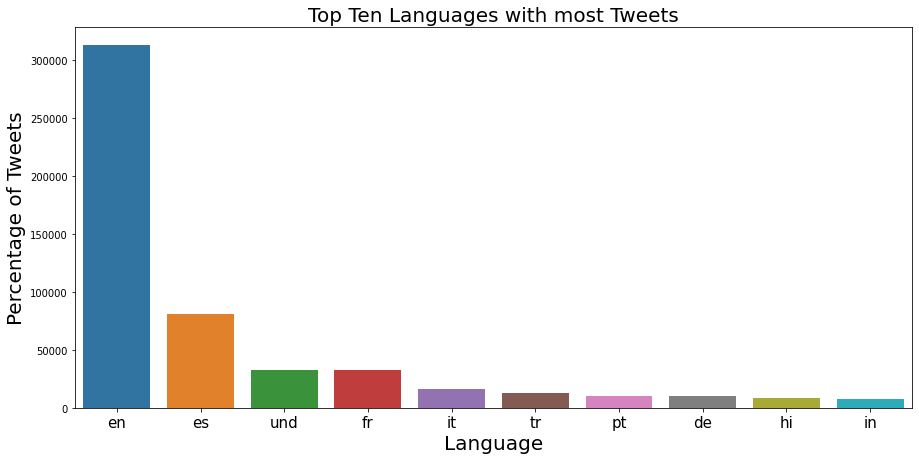

In [ ]:
plt.figure(figsize = (15,7))
sns.barplot(x = df['lang'].value_counts()[:10].index , y = df['lang'].value_counts()[:10])
plt.xlabel('Language', fontsize = 20)
plt.ylabel('Percentage of Tweets', fontsize = 20)
plt.xticks(fontsize = 15)
plt.title('Top Ten Languages with most Tweets', fontsize=20)
plt.show()

In [ ]:
new_df = df[df['lang']=='en']
new_df.head()

,status_id,user_id,created_at,text,account_created_at,verified,lang
2,1.244050e+18,8.094356e+07,2020-03-29T00:00:00Z,ÛÏPeople are just storing up. They are stayin...,2009-10-08T21:06:08Z,False,en
6,1.244050e+18,2.792216e+07,2020-03-29T00:00:00Z,.@PatriceHarrisMD spoke with @YahooFinance abo...,2009-03-31T17:50:31Z,True,en
7,1.244050e+18,1.115875e+09,2020-03-29T00:00:00Z,First medical team aiding #Wuhan in fight agai...,2013-01-24T03:18:59Z,True,en
9,1.244050e+18,1.088453e+08,2020-03-29T00:00:00Z,.@KathyGriffin: @realDonaldTrump Is 'Lying' Ab...,2010-01-27T05:23:15Z,False,en
14,1.244050e+18,1.767364e+07,2020-03-29T00:00:00Z,#CoronaUpdate | Johns Hopkins University has s...,2008-11-27T09:07:38Z,True,en


In [ ]:
new_df1 = new_df.reset_index(inplace = True)
new_df.tail()

,index,status_id,user_id,created_at,text,account_created_at,verified,lang
313031,564135,1.244410e+18,1.085910e+18,2020-03-29T23:59:58Z,"#Trump extends #coronavirus guidelines, braces...",2019-01-17T14:53:18Z,False,en
313032,564136,1.244410e+18,1.028780e+18,2020-03-29T23:59:58Z,A 3rd #NYPD member dies of #coronavirus after ...,2018-08-12T23:21:07Z,False,en
313033,564137,1.244410e+18,8.119196e+07,2020-03-29T23:59:59Z,"For many students in our state, #COVID19 closu...",2009-10-09T20:10:36Z,True,en
313034,564138,1.244410e+18,6.120661e+07,2020-03-29T23:59:59Z,Will the #coronavirus pandemic of 2020 come to...,2009-07-29T14:27:16Z,False,en
313035,564140,1.244410e+18,9.388810e+17,2020-03-29T23:59:59Z,_Ù___ÙÈÛªÛü Is there a way to revoke som...,2017-12-07T21:21:24Z,False,en


In [ ]:
txt = new_df['text']
txt.head()

0    ÛÏPeople are just storing up. They are stayin...
1    .@PatriceHarrisMD spoke with @YahooFinance abo...
2    First medical team aiding #Wuhan in fight agai...
3    .@KathyGriffin: @realDonaldTrump Is 'Lying' Ab...
4    #CoronaUpdate | Johns Hopkins University has s...
Name: text, dtype: object

In [ ]:
#Removing URLs, hashtags from tweets
txt_ru = txt.apply(lambda x: re.sub(r"@\S+", "", str(x)))
txt_ru = txt_ru.apply(lambda x: re.sub(r"https\S+", "", str(x)))
txt_rh = txt_ru.apply(lambda x: re.sub(r"#\S+", "",str(x)))
txt_rh.head()

0    ÛÏPeople are just storing up. They are stayin...
1    . spoke with  about the  stimulus package maki...
2    First medical team aiding  in fight against ep...
3                      .  Is 'Lying' About  Testing   
4     | Johns Hopkins University has said it did no...
Name: text, dtype: object

In [ ]:
#converting tweets to lowercase
txt_lower = txt_rh.apply(lambda x: x.lower())
txt_lower.head()

0    ûïpeople are just storing up. they are stayin...
1    . spoke with  about the  stimulus package maki...
2    first medical team aiding  in fight against ep...
3                      .  is 'lying' about  testing   
4     | johns hopkins university has said it did no...
Name: text, dtype: object

In [ ]:
#removing punctuations
txt_rp = txt_lower.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
txt_rp.head()

0    ûïpeople are just storing up they are staying...
1     spoke with  about the  stimulus package makin...
2    first medical team aiding  in fight against ep...
3                           is lying about  testing   
4      johns hopkins university has said it did not...
Name: text, dtype: object

In [ ]:
#remove special characters
txt_rs = txt_rp.apply(lambda x: re.sub('[^a-zA-Z0-9]', ' ', str(x)))
txt_rs.head()

0       people are just storing up they are staying...
1     spoke with  about the  stimulus package makin...
2    first medical team aiding  in fight against ep...
3                           is lying about  testing   
4      johns hopkins university has said it did not...
Name: text, dtype: object

In [ ]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
#Removing stopwords
stop_words = set(stopwords.words('english'))
#stop_words.update(['#coronavirus', '#coronavirusoutbreak', '#coronavirusPandemic', '#covid19', '#covid_19', '#epitwitter', '#ihavecorona', 'amp', 'coronavirus', 'covid19'])
txt_rstpw = txt_rs.apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
txt_rstpw.head()

0    people storing staying home freezing things ta...
1    spoke stimulus package making way congress hea...
2    first medical team aiding fight epidemic compl...
3                                        lying testing
4    johns hopkins university said authorize use lo...
Name: text, dtype: object

In [ ]:
tweets = txt_rstpw.to_frame()
tweets.head()

,text
0,people storing staying home freezing things ta...
1,spoke stimulus package making way congress hea...
2,first medical team aiding fight epidemic compl...
3,lying testing
4,johns hopkins university said authorize use lo...


In [ ]:
#concat tweets into list of words
word_list = [word for line in txt_rstpw for word in line.split()]
word_list[4:15]

['freezing',
 'things',
 'talk',
 'dealers',
 'around',
 'state',
 'area',
 'freezers',
 'said',
 'owner',
 'frank']

In [ ]:
from wordcloud import STOPWORDS

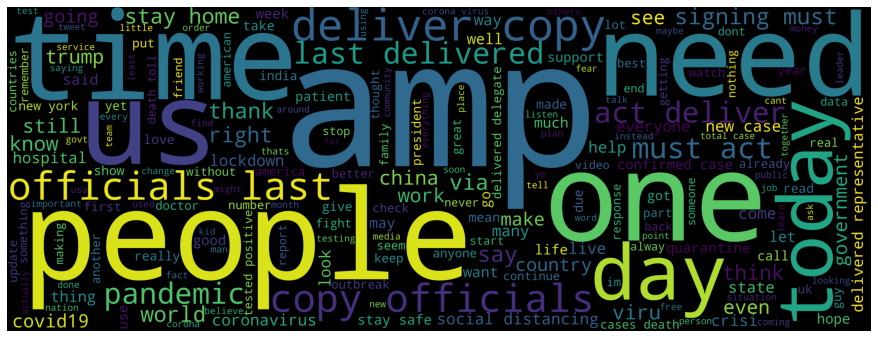

In [ ]:

wordcloud = WordCloud(background_color='black', stopwords=STOPWORDS, height = 3600, width = 9600).generate(' '.join(word_list))


plt.figure(figsize = (12, 10), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.savefig('wordcloud.png')
plt.show()

In [ ]:
nltk.download("vader_lexicon")

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [ ]:
sid = SentimentIntensityAnalyzer()
sentiment_scores = txt_rstpw.apply(lambda x: sid.polarity_scores(x))
sent_scores_df = pd.DataFrame(list(sentiment_scores))
sent_scores_df.head()

,neg,neu,pos,compound
0,0.152,0.848,0.0,-0.1280
1,0.000,1.000,0.0,0.0000
2,0.271,0.729,0.0,-0.3818
3,0.773,0.227,0.0,-0.5267
4,0.000,1.000,0.0,0.0000


In [ ]:
tweets["sentiment"] = sent_scores_df['compound']
tweets.head()

,text,sentiment
0,people storing staying home freezing things ta...,-0.1280
1,spoke stimulus package making way congress hea...,0.0000
2,first medical team aiding fight epidemic compl...,-0.3818
3,lying testing,-0.5267
4,johns hopkins university said authorize use lo...,0.0000


In [ ]:
new_df.drop(['index','verified', 'lang','text', 'account_created_at'], axis =1,inplace = True)

In [ ]:
new_df['clean_text'] = tweets['text']

In [ ]:
new_df.head()

,status_id,user_id,created_at,clean_text
0,1.244050e+18,8.094356e+07,2020-03-29T00:00:00Z,people storing staying home freezing things ta...
1,1.244050e+18,2.792216e+07,2020-03-29T00:00:00Z,spoke stimulus package making way congress hea...
2,1.244050e+18,1.115875e+09,2020-03-29T00:00:00Z,first medical team aiding fight epidemic compl...
3,1.244050e+18,1.088453e+08,2020-03-29T00:00:00Z,lying testing
4,1.244050e+18,1.767364e+07,2020-03-29T00:00:00Z,johns hopkins university said authorize use lo...


In [ ]:
new_df["Polarity"] = sent_scores_df['compound']
new_df.head()

,status_id,user_id,created_at,clean_text,Polarity
0,1.244050e+18,8.094356e+07,2020-03-29T00:00:00Z,people storing staying home freezing things ta...,-0.1280
1,1.244050e+18,2.792216e+07,2020-03-29T00:00:00Z,spoke stimulus package making way congress hea...,0.0000
2,1.244050e+18,1.115875e+09,2020-03-29T00:00:00Z,first medical team aiding fight epidemic compl...,-0.3818
3,1.244050e+18,1.088453e+08,2020-03-29T00:00:00Z,lying testing,-0.5267
4,1.244050e+18,1.767364e+07,2020-03-29T00:00:00Z,johns hopkins university said authorize use lo...,0.0000


In [ ]:
def Polarity_score(data):
  if data['Polarity'] == 0:
    return 'Neu'
  elif data["Polarity"] > 0:
    return 'Pos'
  else:
    return 'Neg'


In [ ]:
new_df['sentiment'] = new_df.apply(Polarity_score, axis=1)
new_df.head(10)

,status_id,user_id,created_at,clean_text,Polarity,sentiment
0,1.244050e+18,8.094356e+07,2020-03-29T00:00:00Z,people storing staying home freezing things ta...,-0.1280,Neg
1,1.244050e+18,2.792216e+07,2020-03-29T00:00:00Z,spoke stimulus package making way congress hea...,0.0000,Neu
2,1.244050e+18,1.115875e+09,2020-03-29T00:00:00Z,first medical team aiding fight epidemic compl...,-0.3818,Neg
3,1.244050e+18,1.088453e+08,2020-03-29T00:00:00Z,lying testing,-0.5267,Neg
4,1.244050e+18,1.767364e+07,2020-03-29T00:00:00Z,johns hopkins university said authorize use lo...,0.0000,Neu
5,1.244050e+18,1.587242e+07,2020-03-29T00:00:00Z,singapore donates 40000 test kits philippines,0.0000,Neu
6,1.244050e+18,1.715487e+08,2020-03-29T00:00:00Z,remarkable week bold policy announcements acco...,0.7351,Pos
7,1.244050e+18,3.426246e+07,2020-03-29T00:00:00Z,activates special protocols fight hide info in...,-0.5859,Neg
8,1.244050e+18,6.464306e+07,2020-03-29T00:00:00Z,lockdowns drones things ever go back normal pa...,0.0000,Neu
9,1.244050e+18,1.084579e+08,2020-03-29T00:00:00Z,pandemic feeling outofcontrol overwhelmed take...,0.1779,Pos


In [ ]:
new_dt = new_df.sample(n = 1500)
new_dt.shape

(1500, 6)

In [ ]:
new_dt.head(10)

,status_id,user_id,created_at,clean_text,Polarity,sentiment
59100,1.244150e+18,3.028260e+09,2020-03-29T06:19:11Z,number death toll rises 25 india union health ...,-0.5574,Neg
72608,1.244170e+18,1.150240e+18,2020-03-29T07:37:35Z,received email joshua school lunch account aut...,-0.6249,Neg
1968,1.244050e+18,1.092940e+18,2020-03-29T00:10:36Z,ask belgium test apparently cats already tested,0.0000,Neu
199553,1.244320e+18,3.343888e+08,2020-03-29T17:28:53Z,sinotech marine press release,0.0000,Neu
73750,1.244170e+18,4.750555e+09,2020-03-29T07:43:55Z,minds african youth must empowered take future...,-0.2960,Neg
25205,1.244090e+18,3.130548e+08,2020-03-29T02:29:48Z,deaths uk reached 1019 biggest daily increase ...,-0.2732,Neg
255406,1.244360e+18,1.287482e+09,2020-03-29T20:30:34Z,brocktonwalkerton supporting brucelea seniors ...,0.7845,Pos
182240,1.244300e+18,2.030601e+08,2020-03-29T16:36:07Z,cair urges officials protect civil rights inma...,0.3818,Pos
55476,1.244140e+18,8.531740e+17,2020-03-29T05:56:18Z,happy sunday tune online service today thank,0.7351,Pos
19791,1.244080e+18,2.340151e+08,2020-03-29T01:56:12Z,definition please god,0.5267,Pos


In [ ]:
new_dt.tail(10)

,status_id,user_id,created_at,clean_text,Polarity,sentiment
83632,1.244180e+18,7.213870e+17,2020-03-29T08:35:17Z,germany reporting disappointingly low death ra...,-0.7003,Neg
230445,1.244340e+18,3.246051e+09,2020-03-29T19:05:14Z,get useless lawn dug get seeds easy soil get e...,0.4215,Pos
296227,1.244400e+18,9.385330e+17,2020-03-29T22:52:56Z,support kay signing must act deliver copy offi...,0.6597,Pos
192493,1.244310e+18,7.772301e+07,2020-03-29T17:06:47Z,anyone countenance travel china anymore,0.0000,Neu
101221,1.244210e+18,8.191660e+17,2020-03-29T10:38:21Z,rna polymerase inhibitormay significantly bett...,0.4404,Pos
251881,1.244360e+18,1.119470e+18,2020-03-29T20:19:40Z,breaking windsoressex 25 positive cases confirms,0.5574,Pos
203461,1.244320e+18,2.376769e+09,2020-03-29T17:41:05Z,lot people asking number recoveries heres know...,0.0772,Pos
122152,1.244240e+18,8.756600e+17,2020-03-29T12:20:32Z,lets defeat together,-0.4588,Neg
100339,1.244210e+18,4.970411e+06,2020-03-29T10:33:44Z,older people vulnerable explains imperative el...,0.2023,Pos
18285,1.244080e+18,4.065194e+08,2020-03-29T01:45:54Z,fda warning use chloroquine phosphate intended...,-0.6705,Neg


In [ ]:
new_dt["Date"] = pd.to_datetime(df["created_at"]).dt.date
new_dt["Time"] = pd.to_datetime(df["created_at"]).dt.time

In [ ]:
new_dt.head()

,status_id,user_id,created_at,clean_text,Polarity,sentiment,Date,Time
59100,1.244150e+18,3.028260e+09,2020-03-29T06:19:11Z,number death toll rises 25 india union health ...,-0.5574,Neg,2020-03-29,03:21:17
72608,1.244170e+18,1.150240e+18,2020-03-29T07:37:35Z,received email joshua school lunch account aut...,-0.6249,Neg,2020-03-29,04:14:34
1968,1.244050e+18,1.092940e+18,2020-03-29T00:10:36Z,ask belgium test apparently cats already tested,0.0000,Neu,2020-03-29,00:05:09
199553,1.244320e+18,3.343888e+08,2020-03-29T17:28:53Z,sinotech marine press release,0.0000,Neu,2020-03-29,11:05:38
73750,1.244170e+18,4.750555e+09,2020-03-29T07:43:55Z,minds african youth must empowered take future...,-0.2960,Neg,2020-03-29,04:18:47


In [ ]:
new_dt["sentiment"].value_counts()

Pos    690
Neg    484
Neu    326
Name: sentiment, dtype: int64

In [ ]:
new_dt.to_csv("Data.csv", index = False)

In [ ]:
from google.colab import files
files.download("Data.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
pos_words = ' '.join([text for text in new_df['clean_text'][new_df['sentiment'] == 'Pos']])

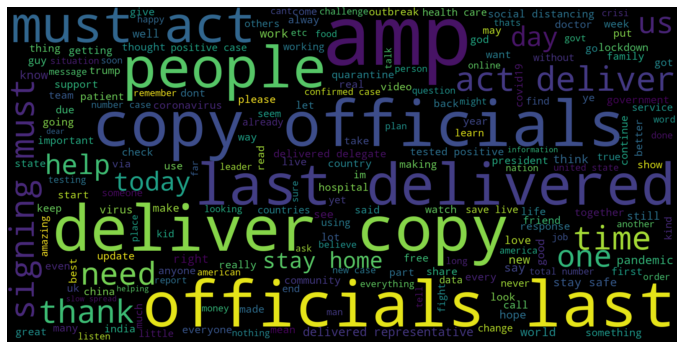

In [ ]:
wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(pos_words)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
neg_words = ' '.join([text for text in new_df['clean_text'][new_df['sentiment'] == 'Neg']])

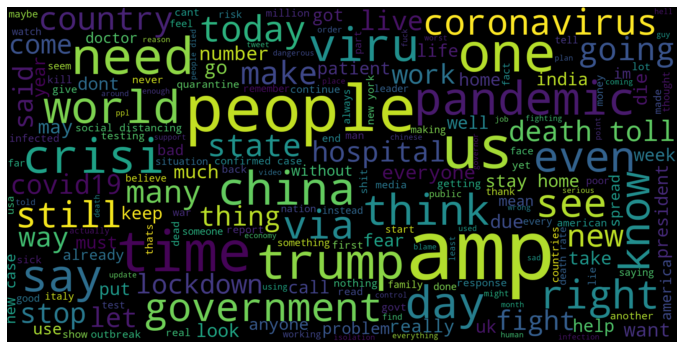

In [ ]:
wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(neg_words)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
neut_words = ' '.join([text for text in new_df['clean_text'][new_df['sentiment'] == 'Neu']])

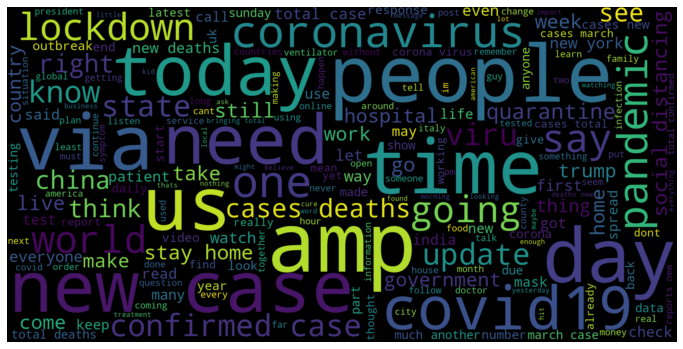

In [ ]:
wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(neut_words)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
# bag-of-words feature matrix
from sklearn.feature_extraction.text import CountVectorizer
bow_vectorizer = CountVectorizer(stop_words='english')

X = bow_vectorizer.fit_transform(txt_rstpw)
y = new_df["sentiment"]

In [ ]:
X.shape

(313036, 129367)

In [ ]:
y.shape

(313036,)

In [ ]:
#splitting the data into train set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [ ]:
classifier = MultinomialNB()
classifier.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [ ]:
y_pred = classifier.predict(X_test)

print("Test accuracy: ",classifier.score(X_test, y_test))
print("Training accuracy: ",classifier.score(X_train, y_train))

Test accuracy:  0.7362797086634296
Training accuracy:  0.7848722986247544


In [ ]:
#on CountVectorizer
from sklearn.svm import LinearSVC
LSVC = LinearSVC()

LSVC.fit(X_train, y_train)
y_pred = LSVC.predict(X_test)
print("Test accuracy: ",LSVC.score(X_test, y_test))
print("Training accuracy: ",LSVC.score(X_train, y_train))


Test accuracy:  0.9189720163557373
Training accuracy:  0.9728864184516108


In [ ]:
from sklearn.tree import DecisionTreeClassifier
DTC = DecisionTreeClassifier()

DTC.fit(X_train, y_train)
y_pred = DTC.predict(X_test)

print("Test accuracy: ",DTC.score(X_test, y_test))
print("Training accuracy: ",DTC.score(X_train, y_train))

Test accuracy:  0.8480705341170457
Training accuracy:  0.9989298321273979


In [ ]:
# TF-IDF feature matrix
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

X = tfidf_vectorizer.fit_transform(txt_rstpw)
y = new_df["sentiment"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [ ]:
classifier = MultinomialNB()
classifier.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [ ]:
y_pred = classifier.predict(X_test)
print("Test accuracy: ",classifier.score(X_test, y_test))
print("Training accuracy: ",classifier.score(X_train, y_train))

Test accuracy:  0.6864617940199336
Training accuracy:  0.7346782308687527


In [ ]:
#on tf-idf
from sklearn.svm import LinearSVC
LSVC = LinearSVC()

LSVC.fit(X_train, y_train)
y_pred = LSVC.predict(X_test)
print("Test accuracy: ",LSVC.score(X_test, y_test))
print("Training accuracy: ",LSVC.score(X_train, y_train))

Test accuracy:  0.9218310759008433
Training accuracy:  0.964217260050793


In [ ]:
from sklearn.tree import DecisionTreeClassifier
DTC = DecisionTreeClassifier()
DTC.fit(X_train, y_train)
y_pred = DTC.predict(X_test)

print("Test accuracy: ",DTC.score(X_test, y_test))
print("Training accuracy: ",DTC.score(X_train, y_train))

Test accuracy:  0.8361710963455149
Training accuracy:  0.9989178526362866
